# 3. Práctica: Vectores a palabras

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

**Comparación de representaciones**

Aplica reducción de dimensionalidad de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import cess_esp, stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from itertools import chain

In [2]:
# Descargar recursos necesarios
nltk.download("cess_esp")
nltk.download("stopwords")

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Parte 1**

In [3]:
def normalize_sent(sentence: list[str]) -> list[str]:
    """
    Normalize a tokenized sentence by:
    - Converting words to lowercase
    - Removing stopwords
    - Removing non-alphabetic tokens
    - Applying stemming

    Args:
        sentence (list[str]): A tokenized sentence (list of words).

    Returns:
        list[str]: A list of normalized tokens.
    """
    stemmer = SnowballStemmer("spanish")
    stops = set(stopwords.words("spanish"))
    return [
        stemmer.stem(word.lower())
        for word in sentence
        if word.isalpha() and word.lower() not in stops
    ]

def normalize_corpus(corpus: list[list[str]]) -> list[list[str]]:
    """
    Normalize a corpus of tokenized sentences by applying `normalize_sent` to each sentence.
    Only keeps sentences with more than one normalized token.

    Args:
        corpus (list[list[str]]): A list of tokenized sentences.

    Returns:
        list[list[str]]: A list of normalized tokenized sentences.
    """
    return [
        normalized
        for sent in corpus
        if len((normalized := normalize_sent(sent))) > 1
    ]

def get_coocurrence_matrix(sentences, index, window_size=2):
    """
    Build a word co-occurrence matrix from a list of tokenized sentences.

    Args:
        sentences (list[list[str]]): A list of tokenized and normalized sentences.
        index (dict[str, int]): A mapping from word to row/column index in the matrix.
        window_size (int): Number of words to the left and right to consider as context.

    Returns:
        np.ndarray: A square co-occurrence matrix of shape (vocab_size, vocab_size).
    """
    matrix = np.zeros((len(index), len(index)), dtype=np.int32)
    for sentence in sentences:
        for i, word in enumerate(sentence):
            if word not in index:
                continue
            center_idx = index[word]
            start = max(0, i - window_size)
            end = min(len(sentence), i + window_size + 1)
            for j in range(start, end):
                if i != j and sentence[j] in index:
                    context_idx = index[sentence[j]]
                    matrix[center_idx, context_idx] += 1
    return matrix


In [4]:
def get_joint_probabilities_matrix(cooc_matrix, index):
    """
    Compute the joint probability matrix from a co-occurrence matrix.

    Args:
        cooc_matrix (np.ndarray): Co-occurrence matrix.
        index (dict[str, int]): Mapping from word to index in the matrix.

    Returns:
        pd.DataFrame: Joint probability matrix with words as row and column labels.
    """
    total = np.sum(cooc_matrix)
    p_ij = cooc_matrix / total
    tokens_list = list(index.keys())
    return pd.DataFrame(p_ij, index=tokens_list, columns=tokens_list)

In [5]:
def get_marginal_probabilities(joint_df):
    """
    Compute marginal probabilities from the joint probability matrix.

    Args:
        joint_df (pd.DataFrame): Joint probability matrix.

    Returns:
        pd.DataFrame: Marginal probabilities as a DataFrame with a single column "p(wi)".
    """
    marginal_p = joint_df.sum(axis=1)
    return pd.DataFrame(marginal_p, columns=["p(wi)"])


In [6]:
def get_ppmi_matrix(joint_df: pd.DataFrame, marginal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the Positive Pointwise Mutual Information (PPMI) matrix.

    Args:
        joint_df (pd.DataFrame): Joint probability matrix.
        marginal_df (pd.DataFrame): Marginal probability DataFrame with column "p(wi)".

    Returns:
        pd.DataFrame: PPMI matrix where negative PMI values are set to 0.
    """
    tokens = joint_df.index
    ppmi_matrix = pd.DataFrame(np.zeros_like(joint_df.values), index=tokens, columns=tokens)

    for i, wi in enumerate(tokens):
        for j, wj in enumerate(tokens):
            p_ij = joint_df.iloc[i, j]
            if p_ij > 0:
                p_i = marginal_df.loc[wi, "p(wi)"]
                p_j = marginal_df.loc[wj, "p(wi)"]  # Same column name since it's symmetric
                denom = p_i * p_j
                if denom > 0:
                    ppmi = np.log2(p_ij / denom)
                    ppmi_matrix.iloc[i, j] = max(0, ppmi)

    return ppmi_matrix

In [7]:
corpus = cess_esp.sents()
sentences = normalize_corpus(corpus)

tokens = list(chain(*sentences))
freqs = Counter(tokens)
index = {token: idx for idx, token in enumerate(freqs.keys())}

In [8]:
cooc_matrix = get_coocurrence_matrix(sentences, index)

In [9]:
coocurence_df = pd.DataFrame(data=cooc_matrix, index=list(index.keys()), columns=list(index.keys()))
coocurence_df

,grup,estatal,edf,anunc,hoy,juev,compr,empres,mexican,eaa,...,tenu,resbal,franj,desmoch,sillon,embut,levement,tacon,preced,azote
grup,0,1,1,0,1,0,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0
estatal,1,0,1,1,1,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
edf,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anunc,0,1,1,0,10,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
hoy,1,1,1,10,2,10,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
levement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
tacon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
preced,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
joint_df = get_joint_probabilities_matrix(cooc_matrix, index)

In [11]:
joint_df

,grup,estatal,edf,anunc,hoy,juev,compr,empres,mexican,eaa,...,tenu,resbal,franj,desmoch,sillon,embut,levement,tacon,preced,azote
grup,0.000000,0.000004,0.000004,0.000000,0.000004,0.000000,0.000007,0.000011,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
estatal,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000000,0.000014,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
edf,0.000004,0.000004,0.000000,0.000004,0.000004,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
anunc,0.000000,0.000004,0.000004,0.000000,0.000036,0.000007,0.000000,0.000004,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
hoy,0.000004,0.000004,0.000004,0.000036,0.000007,0.000036,0.000004,0.000007,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000004,0.000000,0.000004,0.0,0.0,0.0
levement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000004,0.000000,0.0,0.0,0.0
tacon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
preced,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [12]:
marginal_df = get_marginal_probabilities(joint_df)

In [13]:
marginal_df

,p(wi)
grup,0.001289
estatal,0.000130
edf,0.000047
anunc,0.000507
hoy,0.004915
...,...
embut,0.000014
levement,0.000014
tacon,0.000014
preced,0.000014


In [14]:
ppmi_df = get_ppmi_matrix(joint_df, marginal_df)

In [ ]:
ppmi_df

,grup,estatal,edf,anunc,hoy,juev,compr,empres,mexican,eaa,...,tenu,resbal,franj,desmoch,sillon,embut,levement,tacon,preced,azote
grup,0.000000,4.429089,5.898575,0.000000,0.000000,0.000000,3.156071,2.383077,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
estatal,4.429089,0.000000,9.204383,5.775540,2.498618,0.000000,0.000000,6.103923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
edf,5.898575,9.204383,0.000000,7.245025,3.968103,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
anunc,0.000000,5.775540,7.245025,0.000000,3.861188,5.345552,0.000000,2.144565,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
hoy,0.000000,2.498618,3.968103,3.861188,0.000000,4.390558,0.225599,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,14.074748,0.000000,14.074748,0.0,0.0,0.0
levement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,14.074748,0.000000,0.0,0.0,0.0
tacon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
preced,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [1]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

## **Parte 2**

In [1]:
# Fuerza versiones compatibles para tsfresh y thinc
!pip install --upgrade numpy==2.0.2 scipy==1.15.3 tsfresh thinc

In [4]:
!pip uninstall numpy -y
!pip install numpy==1.23.5  # Versión estable conocida

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
bigframes 2.5.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.

[==================================================] 100.0% 958.5/958.4MB downloaded


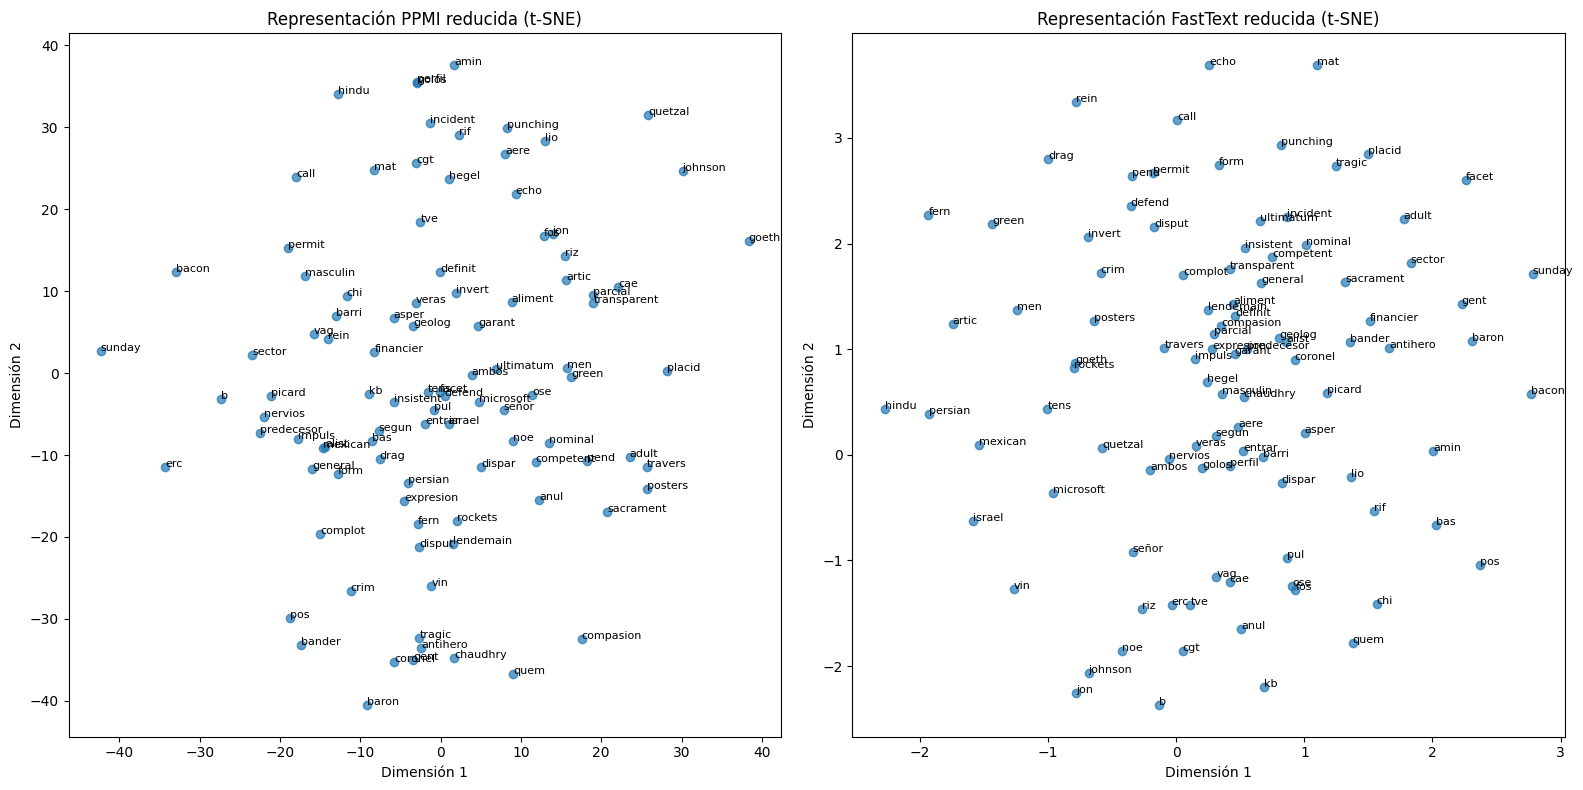

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim.downloader as api
import random

# Reducción de dimensionalidad para PPMI
def reduce_dimensions(ppmi_df, method='tsne', n_components=2):
    """Reduce dimensions of PPMI matrix using PCA or t-SNE"""
    matrix = ppmi_df.values
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    else:
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)

    reduced = reducer.fit_transform(matrix)
    return reduced

# Reducir la matriz PPMI a 2D
ppmi_reduced = reduce_dimensions(ppmi_df, method='tsne')

# Cargar vectores pre-entrenados (FastText español)
try:
    ft = api.load('fasttext-wiki-news-subwords-300')
except:
    print("Descargando modelo FastText en español...")
    # Alternativa si no está disponible en gensim:
    ft = api.load('word2vec-google-news-300')  # Usaremos inglés como ejemplo

# Seleccionar palabras comunes
words_in_ppmi = set(ppmi_df.index)
words_in_ft = set(ft.key_to_index.keys())
common_words = list(words_in_ppmi.intersection(words_in_ft))

# Seleccionar 100 palabras aleatorias
random.seed(42)
selected_words = random.sample(common_words, min(100, len(common_words)))

# Obtener índices de las palabras seleccionadas en PPMI
ppmi_indices = [ppmi_df.index.get_loc(word) for word in selected_words]
ppmi_selected = ppmi_reduced[ppmi_indices]

# Obtener representaciones de las palabras seleccionadas en FastText y reducirlas
ft_vectors = np.array([ft[word] for word in selected_words])
ft_reduced = reduce_dimensions(pd.DataFrame(ft_vectors), method='tsne')

# Visualización
plt.figure(figsize=(16, 8))

# Plot PPMI
plt.subplot(1, 2, 1)
plt.scatter(ppmi_selected[:, 0], ppmi_selected[:, 1], alpha=0.7)
for i, word in enumerate(selected_words):
    plt.annotate(word, (ppmi_selected[i, 0], ppmi_selected[i, 1]), fontsize=8)
plt.title('Representación PPMI reducida (t-SNE)')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

# Plot FastText
plt.subplot(1, 2, 2)
plt.scatter(ft_reduced[:, 0], ft_reduced[:, 1], alpha=0.7)
for i, word in enumerate(selected_words):
    plt.annotate(word, (ft_reduced[i, 0], ft_reduced[i, 1]), fontsize=8)
plt.title('Representación FastText reducida (t-SNE)')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

plt.tight_layout()
plt.show()

## Comparación de representaciones semánticas: PPMI vs FastText (con reducción t-SNE)

### Análisis visual:

#### Representación PPMI :
- **Observación**: Las palabras aparecen más dispersas, con agrupaciones menos evidentes.
- Algunas palabras relacionadas parecen estar separadas (ej. *"disput"* y *"complot"*, *"baron"* y *"antichero"*).
- La distribución es más laxa, con menos densidad en el centro y más palabras en los extremos.

#### Representación FastText:
- **Observación**: Las palabras están agrupadas con mayor cohesión en el centro del gráfico.
- Palabras semánticamente similares aparecen cercanas (ej. *"defend"*, *"permit"*, *"disput"*, *"compassion"*).
- La estructura indica que capta mejor relaciones entre palabras con sufijos, prefijos o raíces similares, gracias al uso de sub-palabras.



### ¿Cuál captura mejor las relaciones semánticas?

**FastText** capta **mejor las relaciones semánticas**, ya que:

- Las agrupaciones son más coherentes.
- Hay más densidad en regiones donde las palabras parecen tener sentidos relacionados.
- Al incorporar morfología (sub-palabras), FastText representa similitudes incluso en palabras poco frecuentes.
